In [57]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

import pickle

import numpy as np
import pandas as pd

In [58]:
RUTA_ARCHIVO = '../data/tarifas_limpias.csv'

In [59]:
data = pd.read_csv(RUTA_ARCHIVO)

In [60]:
# pruebas
data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
data.head()

,compania,nombre_tarifa,tipo_tarifa,potencia_contratada,precio_€/kWh,precio_llano,precio_punta,precio_valle,permanencia
0,Repsol,Ahorro Plus,fija,≤10,0.119746,0.068219,0.068219,0.068219,No
1,Repsol,Mis 10h con Descuento,fija,≤15,0.068219,0.068219,0.068219,0.068219,Sí
2,Repsol,2ª Residencia,fija,≤15,0.054521,0.054521,0.054521,0.054521,Sí
3,Repsol,Mis 3 Horas Gratis,fija,≤15,0.068219,0.068219,0.068219,0.068219,Sí
4,Repsol,Domingos Gratis,fija,≤15,0.068219,0.068219,0.068219,0.068219,Sí


In [61]:
data['potencia_contratada'].unique()

array(['≤10', '≤15', 'Entre 10 y 15', '>15'], dtype=object)

In [62]:
float(data['precio_llano'].mean())

0.11893822666666666

In [63]:
# Preparacion de los datos
# Convertir la columna 'permanencia' a numérica (0 para "no", 1 para "si")
X = data.copy()
X['permanencia'] = X['permanencia'].map({'No': 0, 'Sí': 1})

# Convertir la columna 'tipo_tarifa' a numérica utilizando One-Hot Encoding
X = pd.get_dummies(X, columns=['tipo_tarifa'], drop_first=True)
X = pd.get_dummies(X, columns=['potencia_contratada'], drop_first=True)

In [64]:
X.head(1)

,compania,nombre_tarifa,precio_€/kWh,precio_llano,precio_punta,precio_valle,permanencia,tipo_tarifa_variable,potencia_contratada_Entre 10 y 15,potencia_contratada_≤10,potencia_contratada_≤15
0,Repsol,Ahorro Plus,0.119746,0.068219,0.068219,0.068219,0,False,False,True,False


In [65]:
# Metemos todo menos los nombres
features = X.drop(columns=['compania', 'nombre_tarifa'])

In [66]:
# Escalamos los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [67]:
# Definir el número de clusters
n_clusters = 2  # Puedes ajustar este número

# Crear el modelo de K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a los datos
kmeans.fit(features_scaled)

# Obtener los clusters a los que pertenece cada punto de datos
X['cluster'] = kmeans.labels_

In [68]:
# guardamos el modelo, el escaler y el resultado del cluster de los datos de entrenamiento en un pickle
with open('../data/model_information.pkl', 'wb') as f:
    pickle.dump({'scaler': scaler, 'kmeans': kmeans, 'clustered_data': X}, f)

In [69]:
# Calcular la inercia
print(f'Inercia: {kmeans.inertia_}')

# Calcular el índice de Silhouette
silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
print(f'Índice de Silhouette: {silhouette_avg}')

Inercia: 286.6585673991136
Índice de Silhouette: 0.27848578670136315


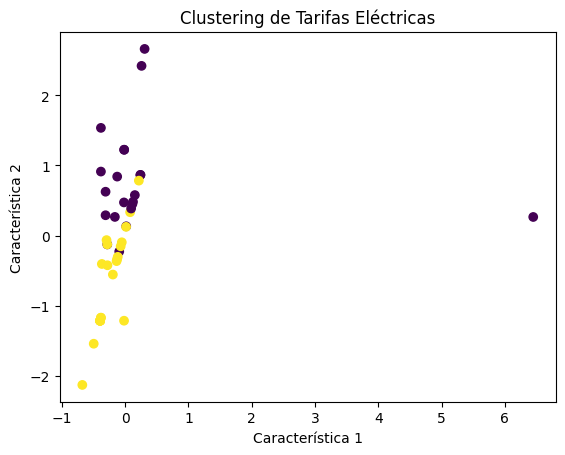

In [70]:
# Visualizar los clusters
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=X['cluster'], cmap='viridis')
plt.title('Clustering de Tarifas Eléctricas')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

In [71]:
# Primero, asegúrate de que solo trabajas con columnas numéricas
numerical_columns = X.select_dtypes(include=['number']).columns

# Agrupar por 'cluster' y calcular la media solo de las columnas numéricas
cluster_summary = X.groupby('cluster')[numerical_columns].mean()

# Mostrar el resumen de los clusters
print(cluster_summary)

         precio_€/kWh  precio_llano  precio_punta  precio_valle  permanencia  \
cluster                                                                        
0            0.160386      0.150979      0.172798      0.130378     0.333333   
1            0.088415      0.090902      0.098947      0.086268     0.375000   

         cluster  
cluster           
0            0.0  
1            1.0  


In [72]:
features.head(1)

,precio_€/kWh,precio_llano,precio_punta,precio_valle,permanencia,tipo_tarifa_variable,potencia_contratada_Entre 10 y 15,potencia_contratada_≤10,potencia_contratada_≤15
0,0.119746,0.068219,0.068219,0.068219,0,False,False,True,False


In [73]:
features.columns

Index(['precio_€/kWh', 'precio_llano', 'precio_punta', 'precio_valle',
       'permanencia', 'tipo_tarifa_variable',
       'potencia_contratada_Entre 10 y 15', 'potencia_contratada_≤10',
       'potencia_contratada_≤15'],
      dtype='object')

In [74]:
# Clasificamos un nuevo dato
nuevo_dato = np.array([[0.119746, 0.068219, 0.068219, 0.068219, 0, False, False, False, True]])
nuevo_dato = pd.DataFrame(nuevo_dato, columns=features.columns)
nuevo_dato_scaled = scaler.transform(nuevo_dato)
cluster_asignado = kmeans.predict(nuevo_dato_scaled)

print(f"El nuevo dato se clasifica en el cluster: {cluster_asignado[0]}")

El nuevo dato se clasifica en el cluster: 1


In [75]:
nuevo_dato['tipo_tarifa_variable'].unique()

array([0.])

In [76]:
# Una vez hemos clasificado un nuevo dato con el kmeans y tenemos su cluster, vamos a mostrar todos las filas de la db que tengan el mismo 
# cluster que el nuevo dato

datos_clasificados = X[X['cluster'] == cluster_asignado[0]]
datos_clasificados.head()

,compania,nombre_tarifa,precio_€/kWh,precio_llano,precio_punta,precio_valle,permanencia,tipo_tarifa_variable,potencia_contratada_Entre 10 y 15,potencia_contratada_≤10,potencia_contratada_≤15,cluster
0,Repsol,Ahorro Plus,0.119746,0.068219,0.068219,0.068219,0,False,False,True,False,1
1,Repsol,Mis 10h con Descuento,0.068219,0.068219,0.068219,0.068219,1,False,False,False,True,1
2,Repsol,2ª Residencia,0.054521,0.054521,0.054521,0.054521,1,False,False,False,True,1
3,Repsol,Mis 3 Horas Gratis,0.068219,0.068219,0.068219,0.068219,1,False,False,False,True,1
4,Repsol,Domingos Gratis,0.068219,0.068219,0.068219,0.068219,1,False,False,False,True,1


In [77]:
# Revertimos los valores del dummies y los del OneHotEncoder a sus valores originales para interpretar los resultados

datos_clasificados['tipo_tarifa'] = datos_clasificados['tipo_tarifa_variable'].map({False: 'fija', True: 'variable'})
datos_clasificados = datos_clasificados.drop(columns=['tipo_tarifa_variable'])

mapeo_potencia = {
    'potencia_contratada_Entre 10 y 15': 'Entre 10 y 15',
    'potencia_contratada_≤10': '≤10',
    'potencia_contratada_≤15': '≤15',
}

# Seleccionar las columnas dummy que quieres revertir
columnas_dummies = ['potencia_contratada_Entre 10 y 15',
                    'potencia_contratada_≤10', 'potencia_contratada_≤15']

# Crear una nueva columna con el valor revertido
datos_clasificados['potencia_contratada'] = datos_clasificados[columnas_dummies].idxmax(axis=1).map(mapeo_potencia)

# Eliminar las columnas dummy si ya no son necesarias
datos_clasificados = datos_clasificados.drop(columns=columnas_dummies)

C:\Users\pabma\AppData\Local\Temp\ipykernel_126936\2902562515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_clasificados['tipo_tarifa'] = datos_clasificados['tipo_tarifa_variable'].map({False: 'fija', True: 'variable'})


In [78]:
print(len(datos_clasificados))
datos_clasificados # Aqui ahora deberiamos hacer un filtro de cuales queremos mostrar al usuario para mejorar su tarifa

24


,compania,nombre_tarifa,precio_€/kWh,precio_llano,precio_punta,precio_valle,permanencia,cluster,tipo_tarifa,potencia_contratada
0,Repsol,Ahorro Plus,0.119746,0.068219,0.068219,0.068219,0,1,fija,≤10
1,Repsol,Mis 10h con Descuento,0.068219,0.068219,0.068219,0.068219,1,1,fija,≤15
2,Repsol,2ª Residencia,0.054521,0.054521,0.054521,0.054521,1,1,fija,≤15
3,Repsol,Mis 3 Horas Gratis,0.068219,0.068219,0.068219,0.068219,1,1,fija,≤15
4,Repsol,Domingos Gratis,0.068219,0.068219,0.068219,0.068219,1,1,fija,≤15
5,Repsol,Descuento Mañana y Tarde,0.068219,0.068219,0.068219,0.068219,1,1,fija,≤15
6,Repsol,Descuento Día,0.068219,0.068219,0.068219,0.068219,1,1,fija,≤15
8,Repsol,Teletrabajo,0.068219,0.068219,0.068219,0.068219,1,1,variable,≤15
9,TotalEnergies,A Tu Aire Luz Siempre,0.104995,0.104995,0.104995,0.104995,0,1,fija,≤15
10,TotalEnergies,Plan Ahora,0.030000,0.030000,0.030000,0.030000,0,1,fija,≤15


In [79]:
nuevo_dato

,precio_€/kWh,precio_llano,precio_punta,precio_valle,permanencia,tipo_tarifa_variable,potencia_contratada_Entre 10 y 15,potencia_contratada_≤10,potencia_contratada_≤15
0,0.119746,0.068219,0.068219,0.068219,0.0,0.0,0.0,0.0,1.0


In [80]:
valor = float(nuevo_dato['precio_€/kWh'].iloc[0])
valor

0.119746

In [81]:
permanencia = int(nuevo_dato['permanencia'].iloc[0])
permanencia

0

In [82]:
print(len(datos_clasificados[(datos_clasificados['precio_€/kWh'] < valor) & (datos_clasificados['permanencia'] == permanencia)]))
datos_clasificados[(datos_clasificados['precio_€/kWh'] < valor) & (datos_clasificados['permanencia'] == permanencia)]

11


,compania,nombre_tarifa,precio_€/kWh,precio_llano,precio_punta,precio_valle,permanencia,cluster,tipo_tarifa,potencia_contratada
9,TotalEnergies,A Tu Aire Luz Siempre,0.104995,0.104995,0.104995,0.104995,0,1,fija,≤15
10,TotalEnergies,Plan Ahora,0.030000,0.030000,0.030000,0.030000,0,1,fija,≤15
11,TotalEnergies,Programa Tu Ahorro,0.084089,0.101222,0.144162,0.084089,0,1,variable,≤15
34,Iberdrola,Plan 3 Periodos,0.083660,0.113646,0.160971,0.083660,0,1,variable,≤15
36,Lucera,Precio coste,0.072000,0.102000,0.151000,0.072000,0,1,variable,≤15
38,Naturgy,Por Uso Luz,0.114900,0.114900,0.114900,0.114900,0,1,fija,≤15
39,Naturgy,Noche Luz,0.082100,0.116200,0.170000,0.082100,0,1,variable,≤15
41,Acciona Energía,Tarifa Variable,0.103700,0.103700,0.103700,0.103700,0,1,variable,≤15
42,Endesa,One Luz,0.112500,0.112500,0.112500,0.112500,0,1,fija,≤15
43,Endesa,Conecta Endesa,0.095700,0.095700,0.095700,0.095700,0,1,fija,≤10


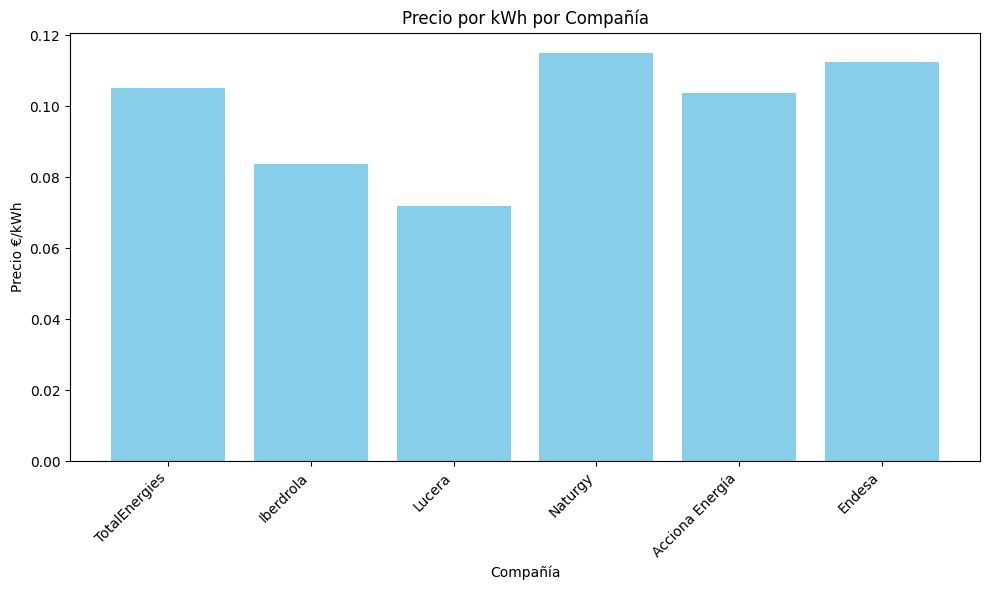

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear el dataframe basado en los datos proporcionados
data = {
    "compania": ["TotalEnergies", "TotalEnergies", "TotalEnergies", "Iberdrola", "Lucera", "Naturgy", "Naturgy", "Acciona Energía", "Endesa", "Endesa", "Endesa"],
    "precio_€/kWh": [0.104995, 0.030000, 0.084089, 0.083660, 0.072000, 0.114900, 0.082100, 0.103700, 0.112500, 0.095700, 0.106250]
}

df = pd.DataFrame(data)

# Graficar el diagrama de barras
plt.figure(figsize=(10, 6))
plt.bar(df['compania'], df['precio_€/kWh'], color='skyblue')
plt.title('Precio por kWh por Compañía')
plt.xlabel('Compañía')
plt.ylabel('Precio €/kWh')
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

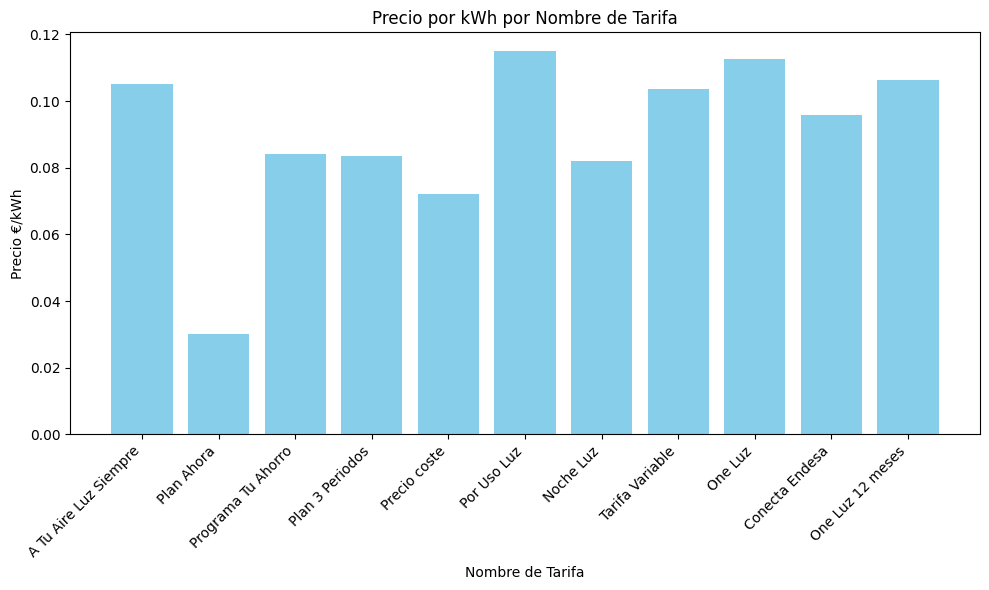

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear el dataframe con los nombres de tarifa
data = {
    "nombre_tarifa": ["A Tu Aire Luz Siempre", "Plan Ahora", "Programa Tu Ahorro", "Plan 3 Periodos", 
                      "Precio coste", "Por Uso Luz", "Noche Luz", "Tarifa Variable", 
                      "One Luz", "Conecta Endesa", "One Luz 12 meses"],
    "precio_€/kWh": [0.104995, 0.030000, 0.084089, 0.083660, 0.072000, 0.114900, 0.082100, 0.103700, 
                     0.112500, 0.095700, 0.106250]
}

df = pd.DataFrame(data)

# Graficar el diagrama de barras
plt.figure(figsize=(10, 6))
plt.bar(df['nombre_tarifa'], df['precio_€/kWh'], color='skyblue')
plt.title('Precio por kWh por Nombre de Tarifa')
plt.xlabel('Nombre de Tarifa')
plt.ylabel('Precio €/kWh')
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()